<a href="https://colab.research.google.com/github/danielruizuleta/Proyecto-Grupo-Argos/blob/main/TP5/Pronostico_Demanda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo Base de Machine Learning

In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import (
    KFold,
    ShuffleSplit,
    cross_val_score,
    learning_curve,
    train_test_split,
)
from sklearn.pipeline import Pipeline

**1. Cargar y explorar los datos**

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 64 entries, 2017-01-01 to 2022-04-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Demand  64 non-null     float64
dtypes: float64(1)
memory usage: 1.0 KB
None
                 Demand
year_month             
2017-01-01  1211.009490
2017-02-01  1660.584649
2017-03-01  3182.587014
2017-04-01  3506.515270
2017-05-01  4554.082280
DatetimeIndex(['2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
               '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01',
               '2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01',
               '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01',
               '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01',
               '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
               '2019-05-01', '2019-06-01', '2019-07-01', 

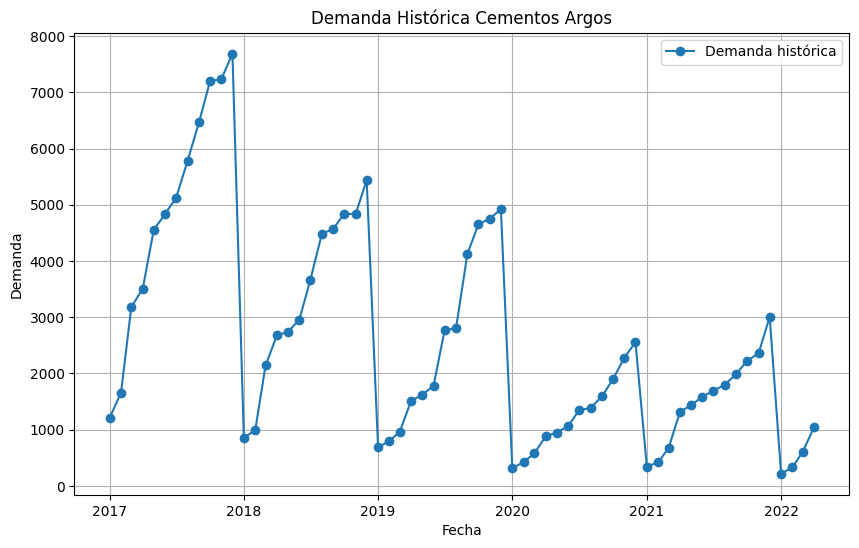

In [ ]:
import pandas as pd

df = pd.read_csv('dataset_demand_acumulate.csv', parse_dates=['year_month'], index_col='year_month')

print(df.info())
print(df.head())

df = df.asfreq('MS')
print(df.index)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Demand'], marker='o', label='Demanda histórica')
plt.title('Demanda Histórica Cementos Argos')
plt.xlabel('Fecha')
plt.ylabel('Demanda')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

# Dividir los datos en entrenamiento (antes de 2022) y validación (2022)
train = df[:'2021-12-31']
test = df['2022-01-01':]

# Usar auto_arima para identificar los mejores hiperparámetros de SARIMA
stepwise_model = auto_arima(
    train['Demand'],
    start_p=1, start_q=1,
    max_p=3, max_q=3,
    seasonal=True, m=12,  # m=12 para datos mensuales
    d=1, D=1,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

print(stepwise_model.summary())


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=4.36 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=739.227, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=734.502, Time=0.98 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.72 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=741.167, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=736.383, Time=0.45 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.21 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=1.04 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.48 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=732.546, Time=0.05 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=734.384, Time=0.35 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.30 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=0.68 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=734.502, Time=0.21 sec

# Modelo de Pronóstico (SARIMA

In [ ]:
model = SARIMAX(
    train['Demand'],
    order=stepwise_model.order,
    seasonal_order=stepwise_model.seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)

# Ajustar el modelo a los datos de entrenamiento
model_fit = model.fit(disp=False)

print(model_fit.summary())


                                     SARIMAX Results                                      
Dep. Variable:                             Demand   No. Observations:                   60
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -271.639
Date:                            Tue, 03 Dec 2024   AIC                            547.278
Time:                                    07:50:17   BIC                            550.389
Sample:                                01-01-2017   HQIC                           548.352
                                     - 12-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.1303      0.184     -0.707      0.480      -0.491       0.231
sigma2      3.227e+05   3.55e+04   

# PREDICCION

In [ ]:
# Predicción para los próximos 3 meses
forecast = model_fit.get_forecast(steps=7)  # Incluye mayo, junio y julio
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Extraer las predicciones relevantes (2022-05, 2022-06, 2022-07)
forecast_df = pd.DataFrame({
    'Predicción': forecast_mean['2022-05-01':'2022-07-01'],
    'Intervalo Inferior': forecast_ci.loc['2022-05-01':'2022-07-01', 'lower Demand'],
    'Intervalo Superior': forecast_ci.loc['2022-05-01':'2022-07-01', 'upper Demand']
})

print(forecast_df)


             Predicción  Intervalo Inferior  Intervalo Superior
2022-05-01  1515.792741         -973.673906         4005.259388
2022-06-01  1657.366978        -1069.707099         4384.441056
2022-07-01  1791.773213        -1153.803447         4737.349873


# GRAFICA DE RESULTADO

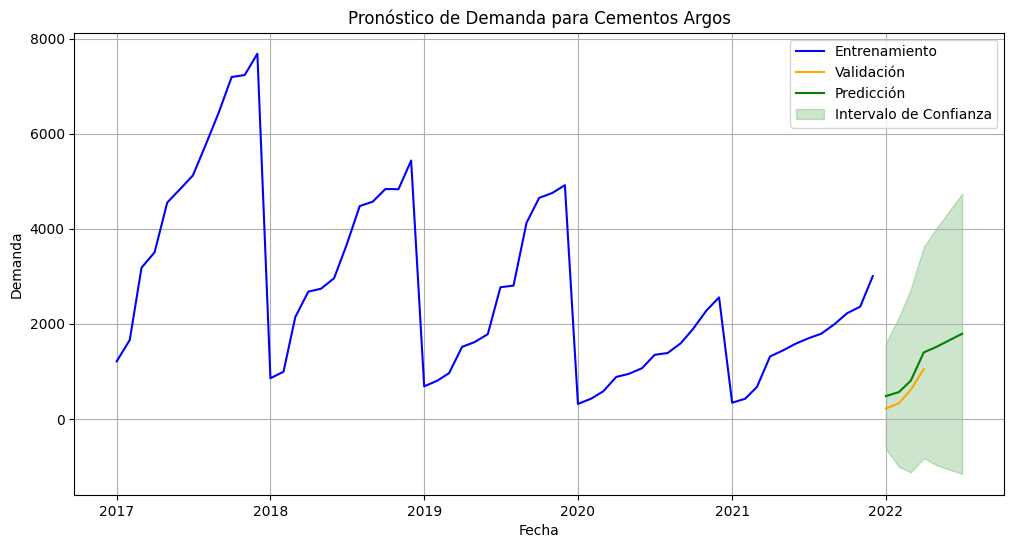

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Demand'], label='Entrenamiento', color='blue')
plt.plot(test.index, test['Demand'], label='Validación', color='orange')
plt.plot(forecast_mean.index, forecast_mean, label='Predicción', color='green')
plt.fill_between(
    forecast_ci.index,
    forecast_ci['lower Demand'],
    forecast_ci['upper Demand'],
    color='green', alpha=0.2, label='Intervalo de Confianza'
)

plt.title('Pronóstico de Demanda para Cementos Argos')
plt.xlabel('Fecha')
plt.ylabel('Demanda')
plt.legend()
plt.grid(True)
plt.show()


# Modelamiento con Prophet

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz4dba8vi/iouom93t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz4dba8vi/44r_ds9b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41402', 'data', 'file=/tmp/tmpz4dba8vi/iouom93t.json', 'init=/tmp/tmpz4dba8vi/44r_ds9b.json', 'output', 'file=/tmp/tmpz4dba8vi/prophet_modelsk7l61ws/prophet_model-20241203075022.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:50:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:50:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future versio

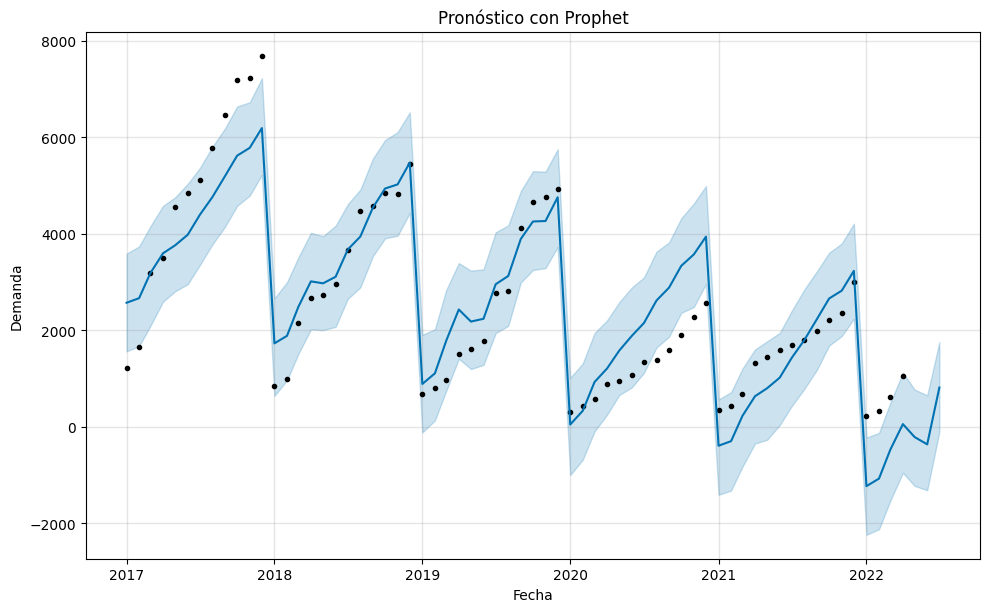

In [ ]:
!pip install prophet

data = pd.read_csv('dataset_demand_acumulate.csv')
data['year_month'] = pd.to_datetime(data['year_month'])
data = data.rename(columns={'year_month': 'ds', 'Demand': 'y'})

model = Prophet(yearly_seasonality=True, daily_seasonality=False)
model.fit(data)

# Crear un DataFrame para predicciones futuras (Mayo, Junio y Julio 2022)
future = model.make_future_dataframe(periods=3, freq='M')
forecast = model.predict(future)

fig = model.plot(forecast)
plt.title('Pronóstico con Prophet')
plt.xlabel('Fecha')
plt.ylabel('Demanda')
plt.show()

forecast[['ds', 'yhat']].to_csv('forecast_with_prophet.csv', index=False)




*   La lína azul es el historico de la demanda.
*   Puntos negros, son la predicción, la cual esta muy cercana a los datos reales, y en general la confianza esta cercana lo cual nos da un indicio de confiabilidad en el modelo predictivo.

